In [1]:

library(ggplot2)
library(ggfortify)
library(gridExtra)
library(arrow)
##install.packages("languageserver") - for R extansion in VS code
#install.packages('IRkernel') and IRkernel::installspec() run in terminal!


Attaching package: ‘arrow’


The following object is masked from ‘package:utils’:

    timestamp




In [3]:
##Calculation of Coefficient of variation
library(dplyr)
library(ggplot2)

input_dir <- "/home/vpal/hobotnica/All_datasets/single_sites_analysis/h_score_result"

files <- list.files(input_dir, full.names = TRUE)

site_scores <- lapply(files, function(file) {
  data <- read.table(file, header = TRUE, stringsAsFactors = FALSE)
  colnames(data) <- c("Column", "Result")
  return(data)
})

combined_data <- bind_rows(site_scores, .id = "File")
cv_data <- combined_data %>%
  group_by(Column) %>%
  summarise(
    Mean = mean(Result, na.rm = TRUE),
    SD = sd(Result, na.rm = TRUE),
    CV = ifelse(Mean > 0, SD / Mean, NA) 
  )

write.table(cv_data, file = "/home/vpal/hobotnica/All_datasets/single_sites_analysis/site_cv_results.txt", sep = "\t", row.names = FALSE, quote = FALSE)

print(summary(cv_data$CV))


Attaching package: ‘dplyr’


The following object is masked from ‘package:gridExtra’:

    combine


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.02411 0.06554 0.08567 0.09106 0.11148 0.23100 


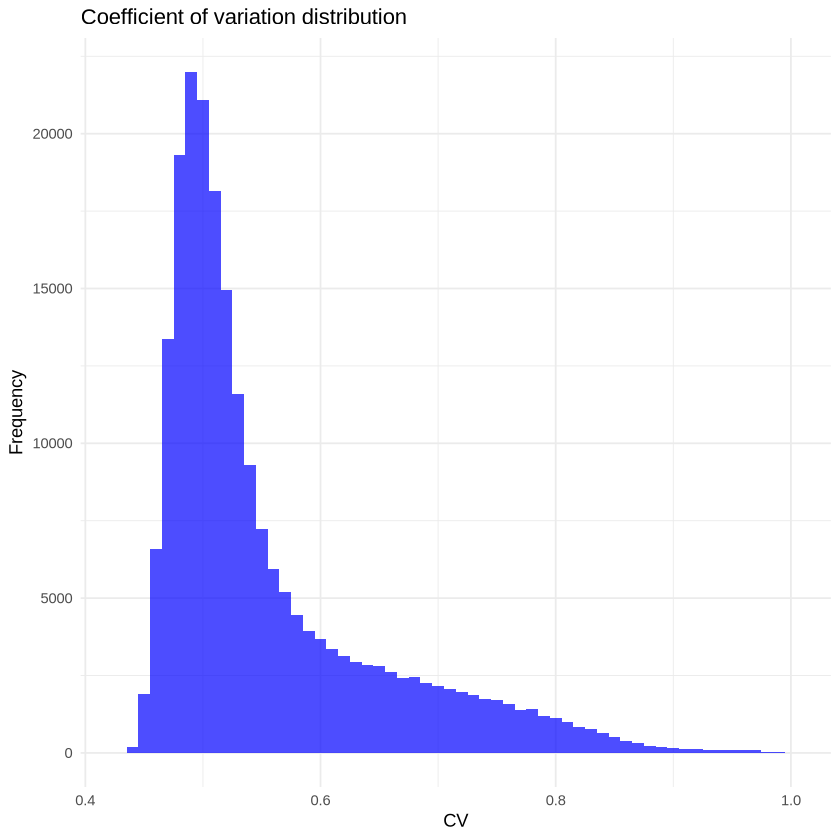

In [5]:

data <- read.table("/home/vpal/hobotnica/All_datasets/single_sites_analysis/h_score_ordered/GSE67751", header = TRUE, stringsAsFactors = FALSE)
ggplot(data, aes(x = Result)) +
  geom_histogram(binwidth = 0.01, fill = "blue", alpha = 0.7) +
  labs(title = "Coefficient of variation distribution",
       x = "CV",
       y = "Frequency") +
  theme_minimal()

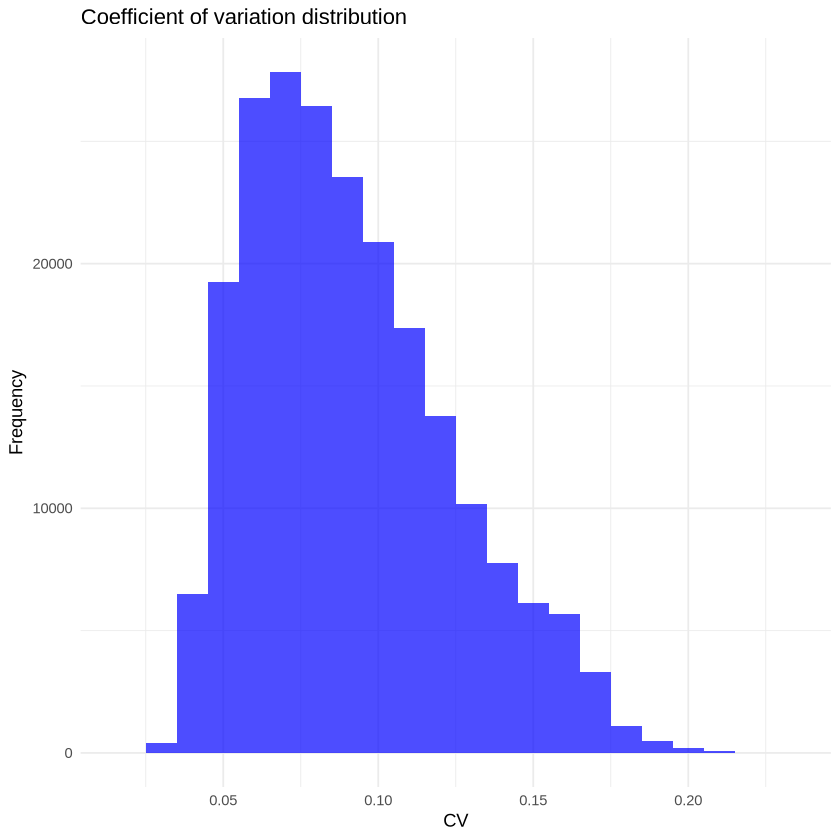

In [5]:
ggplot(cv_data, aes(x = CV)) +
  geom_histogram(binwidth = 0.01, fill = "blue", alpha = 0.7) +
  labs(title = "Coefficient of variation distribution",
       x = "CV",
       y = "Frequency") +
  theme_minimal()

In [ ]:
# ##Here I ordering site by h-scores
# library(dplyr)

# input_dir <- "/home/vpal/hobotnica/All_datasets/single_sites_analysis/h_score_result"
# output_dir_sorted <- "/home/vpal/hobotnica/All_datasets/single_sites_analysis/h_score_ordered"
# dir.create(output_dir_sorted, showWarnings = FALSE, recursive = TRUE)

# files <- list.files(input_dir, full.names = TRUE)

# for (file in files) {
#   data <- read.table(file, header = TRUE, stringsAsFactors = FALSE)
#   colnames(data) <- c("Column", "Result")

#   sorted_data <- data %>%
#     arrange(desc(Result))

#   output_file <- file.path(output_dir_sorted, basename(file))
#   write.table(sorted_data, file = output_file, sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)
# }

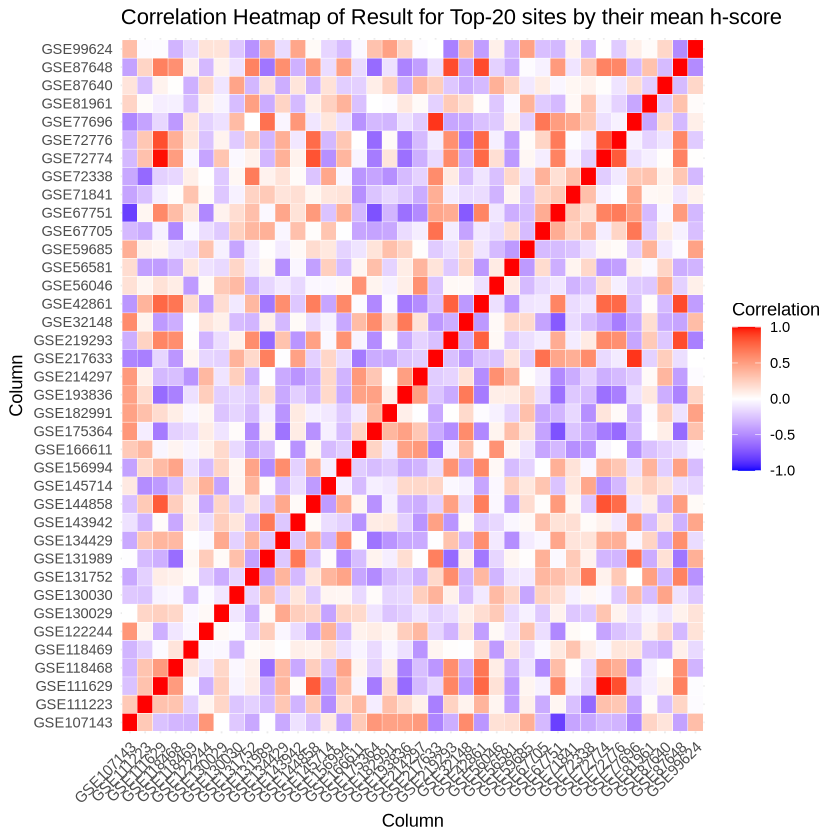

In [71]:
library(dplyr)
library(ggplot2)

input_folder <- "/home/vpal/hobotnica/All_datasets/single_sites_analysis/h_score_result"
files <- list.files(input_folder, full.names = TRUE)

combined_data <- lapply(files, function(file) {
  data <- read.table(file, header = TRUE, stringsAsFactors = FALSE)
  colnames(data) <- c("Column", "Result")  # Rename for consistency
  data$File <- basename(file)  # Add file name as a column
  return(data)
}) %>%
  bind_rows() 

site_stats <- combined_data %>%
  group_by(Column) %>%
  summarise(
    Mean_Result = mean(Result, na.rm = TRUE)
  )

top_20_sites <- site_stats %>%
  arrange(desc(Mean_Result)) %>%
  slice(1:20)

filtered_data <- combined_data %>%
  filter(Column %in% top_20_sites$Column)

h_score_matrix <- reshape(
  filtered_data,
  idvar = "Column",
  timevar = "File",
  direction = "wide"
)

colnames(h_score_matrix) <- gsub("Result\\.", "", colnames(h_score_matrix))  # Clean column names
rownames(h_score_matrix) <- h_score_matrix$Column  # Set site names as rownames
h_score_matrix <- h_score_matrix[, -1]  # Remove the 'Column' column

# Step 7: Compute correlation matrix
cor_matrix <- cor(h_score_matrix, use = "complete.obs")

# Step 8: Reshape correlation matrix for heatmap plotting
melted_cor_matrix <- as.data.frame(as.table(cor_matrix))
colnames(melted_cor_matrix) <- c("Var1", "Var2", "value")  # Rename columns

# Step 9: Plot the correlation heatmap
ggplot(melted_cor_matrix, aes(Var1, Var2, fill = value)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 0, limit = c(-1, 1)) +
  labs(
    title = "Correlation Heatmap of Result for Top-20 sites by their mean h-score",
    x = "Column",
    y = "Column",
    fill = "Correlation"
  ) +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 45, vjust = 1, hjust = 1)
  )

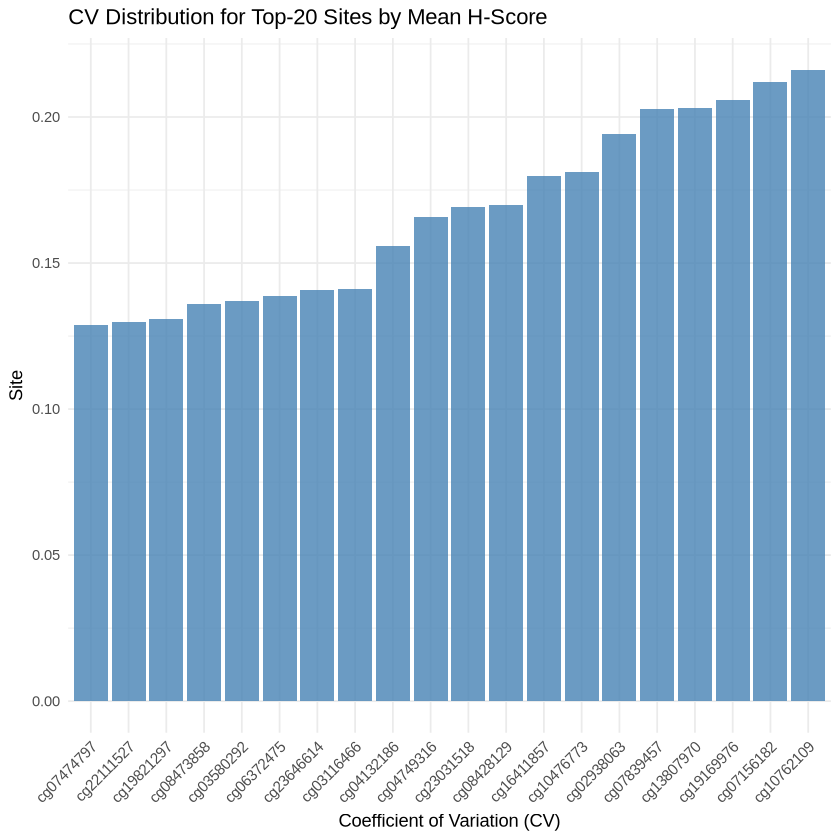

In [12]:
site_scores <- lapply(files, function(file) {
  data <- read.table(file, header = TRUE, stringsAsFactors = FALSE)
  colnames(data) <- c("Site", "H_Score")
  return(data)
})

combined_data <- bind_rows(site_scores, .id = "File")

cv_data <- combined_data %>%
  group_by(Site) %>%
  summarise(
    Mean = mean(H_Score, na.rm = TRUE),
    SD = sd(H_Score, na.rm = TRUE),
    CV = ifelse(Mean > 0, SD / Mean, NA)  # Avoid division by zero
  )

# Step 3: Select top-20 sites with the highest average H-scores
top_20_sites <- cv_data %>% arrange(desc(Mean)) %>% slice(1:20)


# CV distribution for top-20 sites
ggplot(top_20_sites, aes(x = CV, y = reorder(Site, CV))) +
  geom_col(fill = "steelblue", alpha = 0.8) +
  labs(title = "CV Distribution for Top-20 Sites by Mean H-Score",
       x = "Site",
       y = "Coefficient of Variation (CV)") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  coord_flip()

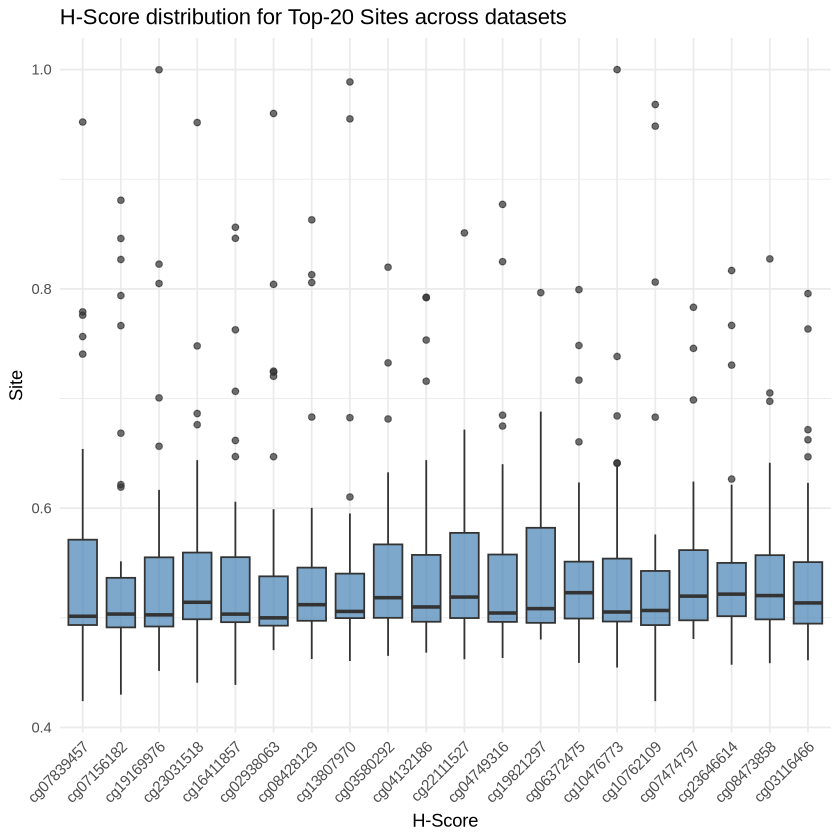

In [17]:
library(dplyr)
library(ggplot2)

input_dir <- "/home/vpal/hobotnica/All_datasets/single_sites_analysis/h_score_ordered"

files <- list.files(input_dir, full.names = TRUE)

site_scores <- lapply(files, function(file) {
  data <- read.table(file, header = TRUE, stringsAsFactors = FALSE)
  colnames(data) <- c("Column", "Result")
  return(data)
})

combined_data <- bind_rows(site_scores, .id = "File")

cv_data <- combined_data %>%
  group_by(Column) %>%
  summarise(
    Mean = mean(Result, na.rm = TRUE)
  )

top_20_sites <- cv_data %>% arrange(desc(Mean)) %>% slice(1:20)

filtered_data <- combined_data %>%
  filter(Column %in% top_20_sites$Column)

ggplot(filtered_data, aes(x = Result, y = reorder(Column, -Result))) +
  geom_boxplot(fill = "steelblue", alpha = 0.7) +
  labs(title = "H-Score distribution for Top-20 Sites across datasets",
       x = "Site",
       y = "H-Score") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  coord_flip()


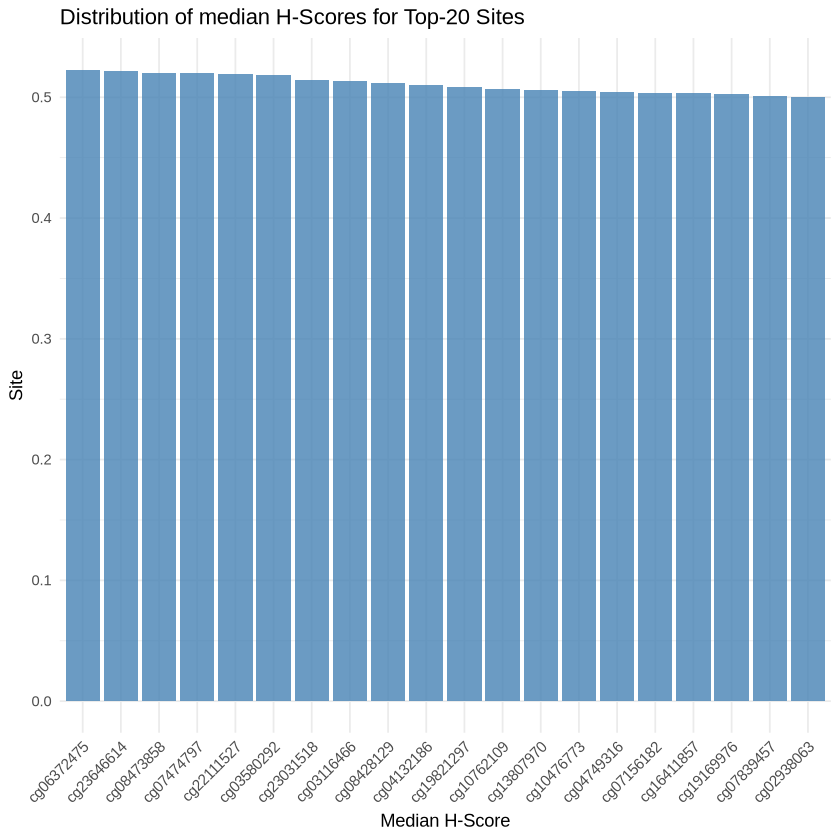

In [18]:
library(dplyr)
library(ggplot2)

# Filter the combined data for only the top-20 sites
filtered_data <- combined_data %>%
  filter(Column %in% top_20_sites$Column)

# Calculate the mean H-scores across files for the top-20 sites
mean_distribution <- filtered_data %>%
  group_by(Column) %>%
  summarise(Mean = median(Result, na.rm = TRUE))

# Plot the distribution of mean H-scores for the top-20 sites
ggplot(mean_distribution, aes(x = Mean, y = reorder(Column, -Mean))) +
  geom_col(fill = "steelblue", alpha = 0.8) +
  labs(title = "Distribution of median H-Scores for Top-20 Sites",
       x = "Site",
       y = "Median H-Score") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
  coord_flip()

In [ ]:
# ##renaming files
# folder_path <- "/home/vpal/hobotnica/All_datasets/single_sites_analysis/h_score_result"

# files <- list.files(folder_path, full.names = TRUE)

# for (file in files) {
#   file_name <- basename(file)
#   new_name <- sub("\\.feather$", "", file_name)
#   new_file_path <- file.path(folder_path, new_name)
#   file.rename(file, new_file_path)
# }

In [ ]:
# library(dplyr)
# library(arrow)
# library(GADES)

# # Input and Output paths
# input_dir <- "/home/vpal/hobotnica/All_datasets/datasets/feather_ds_no_age_39_ds_only_interception"
# output_dir <- "/home/vpal/hobotnica/All_datasets/single_sites_analysis/h_score_result"
# dir.create(output_dir, showWarnings = FALSE, recursive = TRUE)

# # Select a single file for debugging
# file_path <- "/home/vpal/hobotnica/All_datasets/datasets/feather_ds_no_age_39_ds_only_interception/GSE32148.feather"
# file_name <- basename(file_path)
# output_file <- file.path(output_dir, file_name)

# columns_Hobotnica_single <- function(ds, annotation) {
#   excluded_cols <- c("Condition", "Age", "index")
#   columns_to_process <- setdiff(colnames(ds), excluded_cols)
#   total_columns <- length(columns_to_process)
  
#   # Handle cases with no valid columns
#   if (total_columns == 0) {
#     stop("No valid columns to process in the dataset.")
#   }

#   # Initialize results
#   H_scores <- data.frame(Column = character(), Result = numeric(), stringsAsFactors = FALSE)
  
#   # Debugging: Process each column
#   for (col_idx in seq_len(total_columns)) {
#     colname <- columns_to_process[col_idx]
#     cat("Processing column:", colname, "\n")
    
#     # Extract data for the current column
#     column_data <- ds[[colname]]
#     as_matrix <- t(matrix(column_data, ncol = 1))
    
#     # Compute the distance matrix
#     DistMatrix <- mtrx_distance(as_matrix, metric = 'euclidean', type = 'gpu', sparse = FALSE, write = TRUE)
#     cat("Distance matrix computed for column:", colname, "\n")
    
#     # Calculate H-score
#     H_result <- Hobotnica(DistMatrix, annotation)
#     cat("H-score calculated for column:", colname, "\n")
    
#     # Append result
#     H_scores <- rbind(H_scores, data.frame(Column = colname, Result = H_result, stringsAsFactors = FALSE))
#   }
  
#   return(H_scores)
# }


# # Process the selected file
# if (file.exists(output_file)) {
#   cat("Skipping already processed file:", file_name, "\n")
# } else {
#   cat("Processing file:", file_name, "\n")
  
#   # Read the dataset
#   ds <- read_feather(file_path)
#   annotation <- ds$Condition
#   cat("Dataset loaded. Total columns:", ncol(ds), "\n")
  
#   # Calculate H-scores
#   H_scores <- columns_Hobotnica_single(ds, annotation)
  
#   # Save results
#   write.table(H_scores, file = output_file, sep = "\t", row.names = FALSE, col.names = TRUE, quote = FALSE)
#   cat("Processed and saved:", file_name, "\n")
# }

In [1]:
##plot building
# library(ggplot2)
# library(dplyr)
# library(gridExtra)
# library(grid)
# library(tools) 

# folder_path <- "/home/vpal/hobotnica/All_datasets/triplets_h_score_bigger_than_0.5"
# output_pdf <- "/home/vpal/hobotnica/All_datasets/filtered_triplets_res.pdf"

# file_data <- list()
# all_values <- c() 

# for (filename in list.files(folder_path, full.names = TRUE)) {
#   data <- read.table(filename, header = TRUE, sep = "\t", stringsAsFactors = FALSE)
#   data[[4]] <- as.numeric(data[[4]])
#   all_values <- c(all_values, data[[4]])

#   top_10 <- data %>%
#     select(1:4) %>%
#     arrange(desc(data[[4]])) %>%
#     head(10)

#   max_value <- max(top_10[[4]], na.rm = TRUE)
#   file_data[[filename]] <- list(data = data, top_10 = top_10, max_value = max_value)
# }

# x_min <- min(all_values, na.rm = TRUE)
# x_max <- max(all_values, na.rm = TRUE)


# sorted_files <- names(sort(sapply(file_data, function(x) x$max_value), decreasing = TRUE))

# pdf(output_pdf, width = 12, height = 8)

# for (file_name in sorted_files) {
  
#   data <- file_data[[file_name]]$data
#   top_10 <- file_data[[file_name]]$top_10

#   distribution_plot <- ggplot(data, aes(x = data[[4]])) +
#     geom_histogram(bins = 120, fill = "skyblue", color = "black") +
#     labs(title = paste("Distribution for File:", basename(file_name)),
#          x = "Values", y = "Frequency") +
#     xlim(x_min, x_max) +  
#     theme_minimal()

#   top_10_table <- tableGrob(top_10 %>% 
#                               rename(Site1 = Column1, Site2 = Column2, Site3 = Column3, h_score = Result), 
#                             rows = NULL)

#   grid.arrange(distribution_plot, top_10_table, ncol = 2, widths = c(1.5, 1))
# }


# dev.off()

# cat("Plots and tables with consistent x-axis scale saved to:", output_pdf, "\n")

In [ ]:
# library(GADES)

# mtx <- matrix(runif(4), nrow=1)

# dist.matrix <- mtrx_distance(mtx, batch_size = 5000, metric = 'euclidean', type='gpu', sparse=F, write=T)


[1] ""


In [ ]:
# annotation <- c("1", "0", "1", "0")

In [ ]:
# mtx

0.5630733,0.5226046,0.7221978,0.8307175


In [ ]:
# dist.matrix

0.00000000,0.04046881,0.1591245,0.2676441
0.04046881,0.00000000,0.1995933,0.3081129
0.15912449,0.19959331,0.0000000,0.1085196
0.26764411,0.30811292,0.1085196,0.0000000


In [ ]:
# Hobotnica(dist.matrix, annotation)

[1] 0.25

In [2]:
# # calculating the limits before plotting
# library(ggplot2)


# real_h_score_data <- read.csv("/home/vpal/hobotnica/PhenoAgeV2_res_imputed_rand_signature/PhenoAgeV2_final_res.csv")
# real_h_scores_1 <- real_h_score_data$H_score 

# all_random_h_scores <- c()
# all_max_y <- c()

# list_of_files <- list.files("/home/vpal/hobotnica/PhenoAgeV2_res_imputed_rand_signature/distrib_h_score_initial/", full.names = TRUE)

# for (file in list_of_files) {
#   random_h_scores <- scan(file, what = numeric())
#   all_random_h_scores <- c(all_random_h_scores, random_h_scores)
#   hist_data <- hist(random_h_scores, breaks = seq(0, 1, by = 0.001), plot = FALSE)
#   all_max_y <- c(all_max_y, max(hist_data$counts))
# }
# xlim_range <- range(all_random_h_scores)  
# ylim_max <- max(all_max_y) 

# print(paste("X-limits:", paste(xlim_range, collapse = ", ")))
# print(paste("Max Y-limit:", ylim_max))

In [ ]:
##graph for randome signature visualization 
# path_to_initial_H_score_distrib <- "/home/vpal/hobotnica/PhenoAgeV2_res_imputed_rand_signature/distrib_h_score_initial"
# path_to_no_age_H_score_distrib <- "/home/vpal/hobotnica/PhenoAgeV2_res_imputed_rand_signature/distrib_h_score_no_age"
# data_for_pca_initial <- "/home/vpal/hobotnica/datasets_PhenoAgeV2_imputed_NA"
# data_for_pca_no_age <- "/home/vpal/hobotnica/substracted_age_PhenoAgeV2_imputed_NA"

# real_h_scores_data <- read.csv("/home/vpal/hobotnica/PhenoAgeV2_res_imputed_rand_signature/PhenoAgeV2_final_res.csv")
# all_plots <- list()
# #nrow(real_h_scores_data)
# for (i in 1:nrow(real_h_scores_data)) {
#   dataset_name <- real_h_scores_data$Dataset_ID[i]
#   real_h_score <- real_h_scores_data$H_score[i]
#   pval <- real_h_scores_data$p_value[i]
#   real_h_score_no_age <- real_h_scores_data$H_score_no_age[i]
#   pval_no_age <- real_h_scores_data$p_value_no_age[i]
  
#   initial_file <- file.path(path_to_initial_H_score_distrib, paste0("H_score_distrib_", dataset_name, ".txt"))
#   no_age_file <- file.path(path_to_no_age_H_score_distrib, paste0("H_score_distrib_", dataset_name, ".txt"))
  
#   random_h_scores_initial <- scan(initial_file, what = numeric())
#   random_h_scores_no_age <- scan(no_age_file, what = numeric())

#   plot_initial <- plot_signature_distrib(random_h_scores_initial, real_h_score, pval)
#   plot_no_age <- plot_signature_distrib(random_h_scores_no_age, real_h_score_no_age, pval_no_age)
  
#   #pca calculation
#   initial_ds <- file.path(data_for_pca_initial, dataset_name)
#   no_age_ds <- file.path(data_for_pca_no_age, dataset_name)
  
#   initial_ds_data <- read.csv(initial_ds, sep = ",", header = TRUE, row.names = 1)
#   no_age_ds_data <- read.csv(no_age_ds, sep = ",", header = TRUE, row.names = 1)
#   p1 <- PCA_my_plot(initial_ds_data, dataset_name, "initial data")
#   p2 <- PCA_my_plot(no_age_ds_data, dataset_name, "after removing Age variable")
  
#   combined_plot <- arrangeGrob(plot_initial, p1, plot_no_age, p2, ncol = 2, nrow = 2)
#   all_plots[[i]] <- combined_plot
# }

# pdf("Rand_signature_res.pdf", width = 16, height = 16) 
# for (i in seq(1, length(all_plots), by = 1)) {
#   grid.newpage()
#   grid.draw(all_plots[[i]])
# }
# dev.off()


png 
  2

In [ ]:
# #Plot for randome signature H-score distribution
# library(ggplot2)

# plot_signature_distrib <- function(random_h_scores, real_h_score, pval) {
#   random_h_scores <- as.numeric(random_h_scores)
#   real_h_score <- as.numeric(real_h_score)
#   pval <- pval

#   hist_data <- hist(random_h_scores, breaks = seq(0, 1, by = 0.001), plot = FALSE)

#   normalized_counts <- hist_data$counts / sum(hist_data$counts)

#   data <- data.frame(h_scores = hist_data$mids, normalized_counts = normalized_counts)

#   plot <- ggplot(data = data, aes(x = h_scores, y = normalized_counts)) +
#     geom_bar(stat = "identity", fill = "skyblue", color = "black", alpha = 0.9) +
    
#     geom_vline(aes(xintercept = real_h_score), color = "red", linetype = "dashed", size = 0.7) +
    
#     labs(title = "Normalized Distribution of Random h_scores with Real h_score Highlighted",
#          x = "Distribution of Random H-scores",
#          y = "Normalized Frequency") +

#     annotate("text", x = real_h_score - 0.001, 
#              y = max(normalized_counts), 
#              label = paste("H-score =", real_h_score, "\np-value =", pval), 
#              color = "red", vjust = + 1.0) +
    
#     # Set fixed x and y limits
#     xlim(c(0, 1))  +
#     ylim(c(0, max(normalized_counts)))
           
#   return(plot)
# }

In [3]:
Hobotnica <- function(distMatrix, annotation){
    if (typeof(annotation) == "list") {
        annotation <- as.vector(unlist(annotation))
    } else {
        annotation <- as.vector(annotation)
    }
    rank.m <- as.matrix(distMatrix) # transform distance matrix to matrix object
    rank.m[lower.tri(rank.m)] <- rank(rank.m[lower.tri(rank.m)]) # transform distances to ranks
    rank.m[upper.tri(rank.m)] <- rank(rank.m[upper.tri(rank.m)]) #

    inclass_sum <- 0
    classes <- unique(annotation) # unique classes
    Ns <- vector()

    for (i  in 1:length(classes)){

        clas <- classes[i]
        class_samples <- which(annotation == clas)
        l_tmp <- length(class_samples)
        Ns[i] <- l_tmp
        tmp_sum_inclass <- sum(rank.m[class_samples,class_samples]) # sum of ranks, describing in-class distances
        inclass_sum <- inclass_sum + tmp_sum_inclass


    }
    Ns_sum <- sum(Ns)
    biggest_bossible_rank <-  Ns_sum * (Ns_sum - 1)/2
    number_of_unique_inclass_elements <-  sum(Ns * (Ns-1))/2
    maximal_value <- number_of_unique_inclass_elements * (2*biggest_bossible_rank - number_of_unique_inclass_elements + 1)
    minimal_value <- number_of_unique_inclass_elements* (1 + number_of_unique_inclass_elements)

    normalization_factor <- maximal_value - minimal_value
    return (max(0, 1 - (inclass_sum - minimal_value)/normalization_factor ))

}


library(doParallel)
library(GADES)
library(dplyr)  # Ensure all necessary libraries are loaded

ParallelHobotnica <- function(folder_csv_matrices, annotation){
  csv_files <- list.files(folder_csv_matrices, pattern = "\\.csv$", full.names = TRUE)

  num_cores <- detectCores() - 2
  cl <- makeCluster(num_cores)
  registerDoParallel(cl)

  H_scores <- foreach(i = seq_along(csv_files), .packages = c("GADES", "dplyr"),
                      .export = c("Hobotnica"),
                      .combine = 'c') %dopar% {
    subset_matrix <- read.csv(csv_files[i], row.names = 1)
    if ("Condition" %in% colnames(subset_matrix) || "Age" %in% colnames(subset_matrix)) {
    matrix <- subset_matrix %>% select(-Condition, -Age)} 
    else {matrix <- subset_matrix}
      as_matrix <- t(as.matrix(matrix))
      DistMatrix <- mtrx_distance(as_matrix, metric = 'kendall', type='gpu', sparse=FALSE, write=TRUE)
      H_result <- Hobotnica(DistMatrix, annotation)
      return(H_result)
  }
  stopCluster(cl)
  return(H_scores)
}


Loading required package: foreach

Loading required package: iterators

Loading required package: parallel



In [ ]:
#PCA function for plotting

library(ggplot2)
library(dplyr)
library(ggfortify)

PCA_my_plot <- function(data, filename, phrase){

  # Select columns for PCA, excluding 'Condition' and 'Age'
  pca_data <- data %>% select(-Condition, -Age)

  # Convert all columns to numeric
  pca_data <- pca_data %>% mutate_all(as.numeric)

  # Perform PCA
  pca_result <- prcomp(pca_data, center = TRUE, scale. = TRUE)

  # Plot the PCA result with percentage of removed columns as subtitle
   p <- autoplot(pca_result, data = data, colour = 'Condition') +
    labs(title = filename, subtitle = paste0(phrase)) +
    theme(plot.title = element_text(hjust = 0.5),
          plot.subtitle = element_text(hjust = 0.5))

  return(p)
}

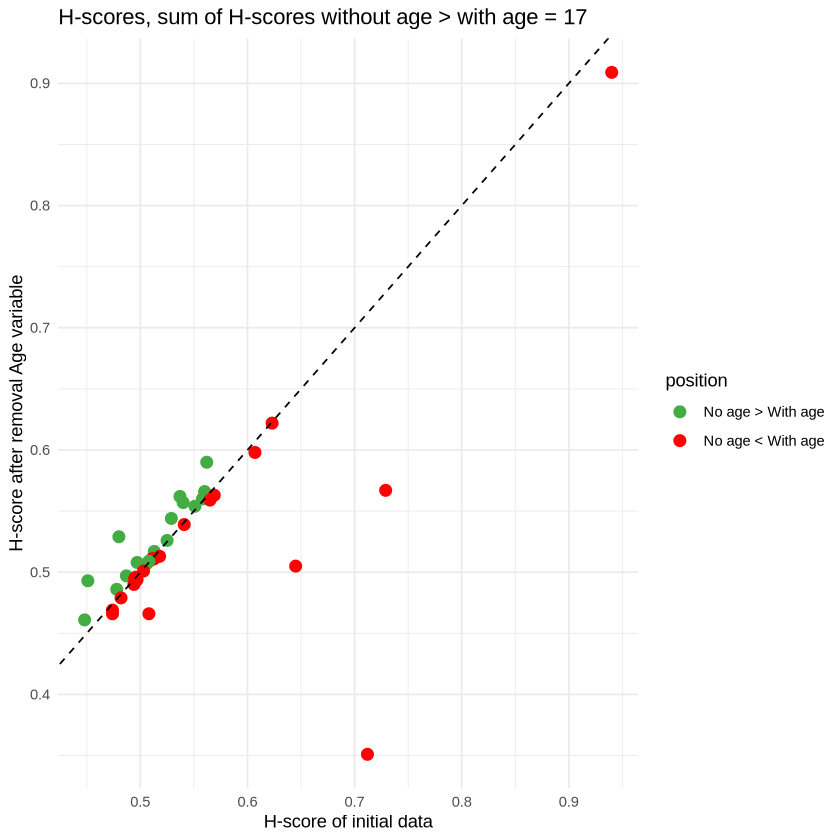

In [ ]:
###Scatter plots for datasets results visualization
library(dplyr)
library(ggplot2)

# Read the CSV file
result <- read.csv("/home/vpal/hobotnica/PhenoAgeV2_res_imputed_rand_signature/PhenoAgeV2_final_res.csv", sep = ",", header = TRUE)

x <- result$H_score
y <- result$H_score_no_age
data <- data.frame(x = x, y = y)

data$position <- ifelse(data$y > data$x, "No age > With age", "No age < With age")
data$position <- factor(data$position, levels = c("No age > With age", "No age < With age"))

calcul <- sum(data$y > data$x)
scatter_plot <- ggplot(data, aes(x = x, y = y)) +
  geom_point(aes(color = position), size = 3) +  
  geom_abline(intercept = 0, slope = 1, linetype = "dashed", color = "black") +  # Line where x = y
  labs(title = paste("H-scores, sum of H-scores without age > with age =", calcul), 
       x = "H-score of initial data",
       y = "H-score after removal Age variable") +
  scale_color_manual(values = c("No age > With age" = "#43ad43", "No age < With age" = "#ff0000fc")) +  # Color points
  theme_minimal() + 
  theme(
    # axis.title = element_blank(),  # Remove axis titles
    # axis.text = element_blank(),  # Remove axis text
    # axis.ticks = element_blank()  # Remove axis ticks
  )

# Print the plot
print(scatter_plot)

In [ ]:
all_plots <- list()

# Iterate through each pair of files
for (i in 1:length(file_list1)) {
  file1 <- file_list1[i]
  file2 <- file_list2[i]

  # Read the data
  data1 <- read.csv(file1, sep = ",", header = TRUE, row.names = 1)
  data2 <- read.csv(file2, sep = ",", header = TRUE, row.names = 1)

  # Plot the distributions
  plot1 <- plot_distrib(distrib_result1)
  plot2 <- plot_distrib(distrib_result2)

  p1 <- PCA_my_plot(data1, sample_id1, "initial data")
  p2 <- PCA_my_plot(data2, sample_id2, "after removing Age variable")
  combined_plot <- arrangeGrob(plot1, p1, plot2, p2, ncol = 2, nrow = 2)
  all_plots[[i]] <- combined_plot

}

# Combine all plots into a single file with 2x2 grid per page
pdf("Rand_signature_res.pdf", width = 16, height = 16) 
for (i in seq(1, length(all_plots), by = 1)) {
  grid.newpage()
  grid.draw(all_plots[[i]])
}
dev.off()
